# Distracted Driving

In [0]:
first_run = False

## Reference

c0 - Safe Driving

c1 - Texting (Right)

c2 - Talking on Phone (Right)

c3 - Texting (Left)

c4 - Talking on Phone (Left)

c5 - Radio

c6 - Drinking

c7 - Reaching Behind

c8 - Hair and Makeup

c9 - Talking to Passenger

## Imports

In [0]:
import os
# os.chdir('/content/drive/My Drive/CS 175/Final Project')
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.models as models
from torch.autograd import Variable
from torch.utils.data import DataLoader
from torch.utils.data import sampler

import torchvision.datasets as dset
import torchvision.transforms as T

import numpy as np

import pandas as pd
import cv2
#from google.colab.patches import cv2_imshow as imshow
import matplotlib.pyplot as plt
import copy


#import timeit

# Get Dataset

## Extract FIles

In [0]:
if first_run:
  !unzip "/content/drive/My Drive/CS 175/Final Project/state-farm-distracted-driver-detection.zip" -d "/content/drive/My Drive/CS 175/Final Project/dset"

In [0]:
if first_run:
  !du "/content/drive/My Drive/CS 175/Final Project/dset/imgs/" -h

## Load Images with CV2

In [0]:
def cv2_load(path, size, color_type=3):
    if color_type == 1: #Grayscale
        img = cv2.imread(path, 0)
    elif color_type == 3: #RGB
        img = cv2.imread(path)
    dim = (int(img.shape[1] * size/100), int(img.shape[0] * size/100)) #Width, Height
    img = cv2.resize(img, dim)
    return img

In [0]:
# plt.imshow(train_dataset[0][0].permute(1, 2, 0) )

### Manually load images
Look through csv file and retrieve each image w/ cv2

In [0]:
manual = False

In [0]:

if manual:
  dataset = pd.read_csv("/content/drive/My Drive/CS 175/Final Project/driver_imgs_list.csv")
  dataset.head(10)

In [0]:
if manual:
  X_train = []
  y_train = []
  for classname, img in dataset[['classname', 'img']].iloc:
    path = os.path.join('/content', 'drive', 'My Drive', 'CS 175', 'Final Project', 'imgs', 'train', classname, img)
    X_train.append(cv2_load(path, 100))
    y_train.append(classname)
    # print('Path:', path)
    # print('CurDir:', os.getcwd())
    # print('Dir:', os.path.isdir(path))
    # print('File:', os.path.isfile(path))
    break
  imshow(X_train[0])

In [0]:
if manual:
  X_train[0]
  train_dataset[0]
  # imshow(T.ToPILImage(train_dataset[0][0]))
  imshow(train_dataset[0][0].numpy().transpose(2,0,1))
  # imshow(np.array(train_dataset[0][0]))

Need to deal with loading in images to dataloader

## Load Dataset with PyTorch

In [0]:
# /content/drive/My Drive/CS 175/Final Project/dset/imgs/
data_path = path = os.path.join('/content', 'drive', 'My Drive', 'CS 175', 'Final Project', 'dset', 'imgs', 'train')
# train_dataset = dset.ImageFolder(root=data_path, transform=T.ToTensor())

transform = T.Compose([T.Resize(256), T.CenterCrop(224), T.ToTensor(), T.Normalize((0.485, 0.456, 0.406),(0.229, 0.224, 0.225))]) #Processing
train_dataset = dset.ImageFolder(root=data_path, transform=transform)

len(train_dataset)

22424

### Use random_split
Doesn't work as a sampler for DataLoader, will come back to make sampler if random sampler doesn't work

In [0]:
random_split = False

In [0]:
def split_data(dataset, split_ratio):
  split = int(split_ratio * len(dataset))
  return torch.utils.data.random_split(dataset, (split, len(dataset)-split))

In [0]:
if random_split:
  train_data, val_data = split_data(train_dataset, 0.7)
  len(train_data), len(val_data)

pytorch.ipynb
```
class ChunkSampler(sampler.Sampler):
    """Samples elements sequentially from some offset. 
    Arguments:
        num_samples: # of desired datapoints
        start: offset where we should start selecting from
    """
    def __init__(self, num_samples, start = 0):
        self.num_samples = num_samples
        self.start = start

    def __iter__(self):
        return iter(range(self.start, self.start + self.num_samples))

    def __len__(self):
        return self.num_samples

NUM_TRAIN = 49000
NUM_VAL = 1000

loader_train = DataLoader(train_data, batch_size=64, sampler=ChunkSampler(NUM_TRAIN, 0))
loader_val = DataLoader(train_data, batch_size=64, sampler=ChunkSampler(NUM_VAL, NUM_TRAIN))
```

### Use SubsetRandomSampler

In [0]:
# Pytorch.ipynb
# loader_train = DataLoader(cifar10_train, batch_size=64, sampler=ChunkSampler(NUM_TRAIN, 0))

https://stackoverflow.com/questions/50544730/how-do-i-split-a-custom-dataset-into-training-and-test-datasets:
```
dataset = CustomDatasetFromCSV(my_path)
batch_size = 16
validation_split = .2
shuffle_dataset = True
random_seed= 42

# Creating data indices for training and validation splits:
dataset_size = len(dataset)
indices = list(range(dataset_size))
split = int(np.floor(validation_split * dataset_size))
if shuffle_dataset :
    np.random.seed(random_seed)
    np.random.shuffle(indices)
train_indices, val_indices = indices[split:], indices[:split]

# Creating PT data samplers and loaders:
train_sampler = SubsetRandomSampler(train_indices)
valid_sampler = SubsetRandomSampler(val_indices)

train_loader = torch.utils.data.DataLoader(dataset, batch_size=batch_size, 
                                           sampler=train_sampler)
validation_loader = torch.utils.data.DataLoader(dataset, batch_size=batch_size,
                                                sampler=valid_sampler)

# Usage Example:
num_epochs = 10
for epoch in range(num_epochs):
    # Train:   
    for batch_index, (faces, labels) in enumerate(train_loader):
        # ...
```

Split dataset to training/validation sets

In [0]:
split_ratio = 0.2
seed = 0
bs = 64 #out of mem
bs = 1

ds_size = len(train_dataset)
ind = list(range(ds_size))
split = int(split_ratio * ds_size)

np.random.seed(seed)
np.random.shuffle(ind)
train_ind, val_ind = ind[split:], ind[:split]


loader_train = torch.utils.data.DataLoader(train_dataset, batch_size=bs, sampler=sampler.SubsetRandomSampler(train_ind))
loader_val = torch.utils.data.DataLoader(train_dataset, batch_size=bs, sampler=sampler.SubsetRandomSampler(val_ind))
len(loader_train), len(loader_val)

(17940, 4484)

# Training

## PyTorch.ipynb
Cells from PyTorch.ipynb as framework for training/checking validation and testing old model from CIFAR-10

### Initialization
Define functions etc.

In [0]:
#PyTorch.ipynb
dtype = torch.FloatTensor # CPU datatype
gpu_dtype = torch.cuda.FloatTensor # GPU datatype

# Constant to control how frequently we print train loss
print_every = 100

# This is a little utility that we'll use to reset the model
# if we want to re-initialize all our parameters
def reset(m):
    if hasattr(m, 'reset_parameters'):
        m.reset_parameters()

In [0]:
#modified from PyTorch.ipynb
def train(model, loss_fn, optimizer, num_epochs = 1, data_type = gpu_dtype):
    for epoch in range(num_epochs):
        # print('Starting epoch %d / %d' % (epoch + 1, num_epochs))
        model.train()
        for t, (x, y) in enumerate(loader_train):
            x_var = x
            y_var = y
            # x_var = Variable(x.type(data_type))
            # y_var = Variable(y.type(data_type).long())
            if data_type == gpu_dtype:
              x_var = x_var.cuda()
              y_var = y_var.cuda()
 
            scores = model(x_var)
            
            loss = loss_fn(scores, y_var)
            if (t + 1) % print_every == 0:
                print('t = %d, loss = %.4f' % (t + 1, loss.item()))
 
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
 

In [0]:
#PyTorch.ipynb
def check_accuracy(model, loader, data_type = gpu_dtype):
    # if loader.dataset.train:
    #     print('Checking accuracy on validation set')
    # else:
    #     print('Checking accuracy on test set')
    print('Checking Accuracy')
    num_correct = 0
    num_samples = 0
    model.eval() # Put the model in test mode (the opposite of model.train(), essentially)
    size = len(loader)
    percent = 0
    for n, (x, y) in enumerate(loader):
        if int(100*n/size) > percent:
          percent = int(100*n/size)
          print(f'{percent}%: {n}/{size}')
        with torch.no_grad():
            x_var = Variable(x.type(data_type))
 
        scores = model(x_var)
        if data_type == gpu_dtype:
            _, preds = scores.data.cpu().max(1)
        else:
            _, preds = scores.data.max(1)
        num_correct += (preds == y).sum()
        num_samples += preds.size(0)
    acc = float(num_correct) / num_samples
    print('Got %d / %d correct (%.2f)' % (num_correct, num_samples, 100 * acc))
    return 100 * acc

In [0]:
#PyTorch.ipynb
class Flatten(nn.Module):
    def forward(self, x):
        global first
        N, C, H, W = x.size() # read in N, C, H, W
        if first == 0:
            if debug: print(f'Flatten: {N}x{C}x{H}x{W} -> {N}x{C*H*W}')
            first = 1
        return x.view(N, -1)  # "flatten" the C * H * W values into a single vector per image

### Test my previously model on CIFAR-10
Use as reference point for vgg16

In [0]:
old_model = False
first = 0
debug = False

class Size(nn.Module):
    def forward(self, x):
        global first
        size = x.size()
        if first == 0:
            if debug: print(size)
        return x
    
class Space(nn.Module):
    def forward(self, x):
        global first
        if first == 0:
            if debug: print()
            first = 1
        return x
        
f1 = 32
f2 = f1*2
f3 = f2*2
s1 = 3
model = nn.Sequential(
    nn.Conv2d(3, f1, s1, padding=1),
    nn.ReLU(True),
    nn.BatchNorm2d(f1),
    nn.Conv2d(f1, f1, s1, padding=1),
    nn.ReLU(True),
    nn.BatchNorm2d(f1),
    nn.MaxPool2d(2,2),
    nn.Dropout(0.2),
    Size(), #16

    nn.Conv2d(f1, f2, s1, padding=1),
    nn.ReLU(True),
    nn.BatchNorm2d(f2),
    nn.Conv2d(f2, f2, s1, padding=1),
    nn.ReLU(True),
    nn.BatchNorm2d(f2),
    nn.MaxPool2d(2,2),
    nn.Dropout(0.3),
    Size(), #8

    nn.Conv2d(f2, f3, s1, padding=1),
    nn.ReLU(True),
    nn.BatchNorm2d(f3),
    nn.Conv2d(f3, f3, s1, padding=1),
    nn.ReLU(True),
    nn.BatchNorm2d(f3),
    nn.MaxPool2d(2,2),
    nn.Dropout(0.4),
    Size(), #4

    Flatten(),
    nn.Linear(128*28*28, 1024),
    nn.Dropout(0.3),
    nn.ReLU(True),
    nn.Linear(1024,10),
    Space()
)


loss = nn.CrossEntropyLoss().type(gpu_dtype)
opt = optim.RMSprop(model.parameters(), lr=5e-4)

if old_model:
  model = model.type(gpu_dtype)
  model.apply(reset)
  train(model, loss, opt, num_epochs=1)
  val_acc = check_accuracy(model, loader_val)
  print(val_acc)

# End Result
# Got 2759 / 4484 correct (61.53)
# 61.52988403211418

## VGG16
Begin looking into VGG16 for training

### Train vgg16
Try training vgg16 from scratch to see performance without transfer learning

In [0]:
vgg16 = models.vgg16()

In [0]:
untrained = False
model = vgg16
 
loss = nn.CrossEntropyLoss().type(gpu_dtype)
opt = optim.RMSprop(model.parameters(), lr=5e-4)
if untrained:
  model = model.type(gpu_dtype)
  model.apply(reset)
  train(model, loss, opt, num_epochs=1)
  # train_acc = check_accuracy(model, loader_train)
  val_acc = check_accuracy(model, loader_val)
  print(val_acc)

#Low accuracy

## Test Pretrained vgg16
Make use of transfer learning

Ref: https://www.kaggle.com/carloalbertobarbano/vgg16-transfer-learning-pytorch,

https://towardsdatascience.com/transfer-learning-with-convolutional-neural-networks-in-pytorch-dd09190245ce

In [0]:
pt_vgg16 = models.vgg16(pretrained=True)

Downloading: "https://download.pytorch.org/models/vgg16-397923af.pth" to /root/.cache/torch/checkpoints/vgg16-397923af.pth


### Only Replace last linear layer
Only replace last linear layer to change output features



https://www.kaggle.com/carloalbertobarbano/vgg16-transfer-learning-pytorch
```
# Load the pretrained model from pytorch
vgg16 = models.vgg16_bn()
vgg16.load_state_dict(torch.load("../input/vgg16bn/vgg16_bn.pth"))
print(vgg16.classifier[6].out_features) # 1000 


# Freeze training for all layers
for param in vgg16.features.parameters():
    param.require_grad = False

# Newly created modules have require_grad=True by default
num_features = vgg16.classifier[6].in_features
features = list(vgg16.classifier.children())[:-1] # Remove last layer
features.extend([nn.Linear(num_features, len(class_names))]) # Add our layer with 4 outputs
vgg16.classifier = nn.Sequential(*features) # Replace the model classifier
print(vgg16)
```

Create copy of pretrained vgg16

In [0]:
import copy
model = copy.deepcopy(pt_vgg16)

Freeze weights



In [0]:
for param in model.parameters():
    param.requires_grad = False

In [0]:
print(model.classifier[6].out_features)

1000


Currently 1000 output features, change last linear layer to have 10 output features

In [0]:
in_feat = model.classifier[6].in_features
features = list(model.classifier.children())[:-1]
features.extend([nn.Linear(in_feat, 10)]) #Add layer with 10 class output
model.classifier = nn.Sequential(*features)
print(model)

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1

In [0]:
pt_1 = False #Pretrained 1

loss = nn.CrossEntropyLoss().type(gpu_dtype)
opt = optim.RMSprop(model.parameters(), lr=5e-4)
if pt_1:
  model = model.type(gpu_dtype)
  train(model, loss, opt, num_epochs=1)
  val_acc = check_accuracy(model, loader_val)
  print(val_acc)


# Accuracy: 
# Got 3820 / 4484 correct (85.19)
# 85.19179304192686

### Add new classifier at the end of VGG16
Add new classifier after feature identification

https://towardsdatascience.com/transfer-learning-with-convolutional-neural-networks-in-pytorch-dd09190245ce
```
import torch.nn as nn
# Add on classifier
model.classifier[6] = nn.Sequential(
                      nn.Linear(n_inputs, 256), 
                      nn.ReLU(), 
                      nn.Dropout(0.4),
                      nn.Linear(256, n_classes),                   
                      nn.LogSoftmax(dim=1))
```

#### Test example classifier above:

Create copy of pretrained vgg16

In [0]:
import copy
model = copy.deepcopy(pt_vgg16)

Freeze weights



In [0]:
for param in model.parameters():
    param.requires_grad = False

In [0]:
in_feat = model.classifier[6].in_features
model.classifier[6] = nn.Sequential(
                      nn.Linear(in_feat, 256), 
                      nn.ReLU(), 
                      nn.Dropout(0.4),
                      nn.Linear(256, 10),                   
                      nn.LogSoftmax(dim=1))
print(model)

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1

Test changed model

In [0]:
pt_2 = False #Pretrained 2

loss = nn.CrossEntropyLoss().type(gpu_dtype)
opt = optim.RMSprop(model.parameters(), lr=5e-4)
if pt_2:
  model = model.type(gpu_dtype)
  train(model, loss, opt, num_epochs=1)
  val_acc = check_accuracy(model, loader_val)
  print(val_acc)


#Accuracy:
# Got 3452 / 4484 correct (76.98)
# 76.98483496877788

changed classifier seems less effective with the sample classifier

### Start Training weights without modified classifier

Since the sample classifier seemed to perform worse, I decide to stick with only replacing the last linear layer for output features and training while saving weights

Create copy of pretrained vgg16

In [0]:
import copy
model = copy.deepcopy(pt_vgg16)

Freeze weights



In [0]:
for param in model.parameters():
    param.requires_grad = False

In [0]:
print(model.classifier[6].out_features)

1000


Currently 1000 output features, change last linear layer to have 10 output features

In [0]:
in_feat = model.classifier[6].in_features
features = list(model.classifier.children())[:-1]
features.extend([nn.Linear(in_feat, 10)]) #Add layer with 10 class output
model.classifier = nn.Sequential(*features)

#print(model)

Save default model weights

In [0]:
default_save_path = os.path.join('/content', 'drive', 'My Drive', 'CS 175', 'Final Project', 'default_model.pth')
epoch = 0
state = {
    'epoch': epoch,
    'state_dict': model.state_dict(),
    'validation': {}
}
torch.save(state, default_save_path)

#### Training epochs
Start training epochs w/ saving

In [0]:
pt_3 = False #Pretrained 3
first_run = False
save_path = os.path.join('/content', 'drive', 'My Drive', 'CS 175', 'Final Project', 'model.pth')
train_epochs = 2 #Number of epochs for this run
epoch = 0 #Number of completed epochs

if pt_3:
  if not first_run: #Load weights if possible
    try:
      checkpoint = torch.load(save_path)
      model.load_state_dict(checkpoint['state_dict'])
      epoch = checkpoint['epoch']
      print('Weights Loaded')
    except Exception as e:
      print(f'{e}: Weights Not Loaded')

  loss = nn.CrossEntropyLoss().type(gpu_dtype)
  opt = optim.RMSprop(model.parameters(), lr=5e-4)

  #Train model
  model = model.type(gpu_dtype)
  train(model, loss, opt, num_epochs=train_epochs)
  val_acc = check_accuracy(model, loader_val)

  #increment epochs
  epoch += train_epochs
  print(f'{epoch} epochs: {val_acc}')

  #Save weights if wanted
  save = input("Save Model? (Y/N): ")
  if save.lower() == 'y':
    state = {
        'epoch': epoch,
        'state_dict': model.state_dict()
    }
    torch.save(state, save_path)
    print('Saved')
  else:
    print('Not Saved')


#Epoch 1: 84%
#Epoch 2: 90%
#Epoch 5: 94.4%s

Weights Loaded


#### Save Validation per epoch
Save validation for each epoch for plotting

In [0]:
pt_4 = True #Pretrained 4
train_epochs = 5 #Number of epochs to train this time

#Wrap training to add validation to dict
def epoch_train(epoch, validation, model, loss, opt, num_epochs = 1):
  for e in range(num_epochs):
    print(f'Training epoch {e+1}/{num_epochs}')
    train(model, loss, opt, num_epochs=1) #Run 1epoch multiple times
    val_acc = check_accuracy(model, loader_val)
    epoch += 1
    print(f'{epoch} epochs: {val_acc}')
    validation[epoch] = val_acc #Add accuracy to validations
  return epoch

def save_weights(epoch, state_dict, val):
  state = {
    'epoch': epoch,
    'state_dict': model.state_dict(),
    'validation': validation
  }
  torch.save(state, save_path)


save_path = os.path.join('/content', 'drive', 'My Drive', 'CS 175', 'Final Project', 'model.pth')
default_save_path = os.path.join('/content', 'drive', 'My Drive', 'CS 175', 'Final Project', 'default_model.pth')
first_run = False

# epoch = 0 #Number of completed epochs
# validations = {} #Maps epochs to validation accuracy

if pt_4:
  if first_run: #Load default vgg16 weights saved earlier
    path = default_save_path
  else: #Load weights if possible
    path = save_path

  try: #Load checkpoint data
    checkpoint = torch.load(path)
    model.load_state_dict(checkpoint['state_dict'])
    epoch = checkpoint['epoch']
    validation = checkpoint['validation']
    print('Weights Loaded')
  except Exception as e:
    print(f'{e}: Weights Not Loaded')
    epoch = 0
    validation = {}

  #Set model to GPU if not already
  model = model.type(gpu_dtype)
  model.cuda()

  loss = nn.CrossEntropyLoss().type(gpu_dtype)
  opt = optim.RMSprop(model.parameters(), lr=5e-4)

  
  #Train model
  epoch = epoch_train(epoch, validation, model, loss, opt, num_epochs=train_epochs)

  #Save weights if wanted
  save = input("Save Model? (Y/N): ")
  if save.lower() == 'y':
    save_weights(epoch, model.state_dict(), validation)
    print('Saved')
  else:
    print('Not Saved')

Weights Loaded
Training epoch 1/5
t = 100, loss = 2.9979
t = 200, loss = 0.0862
t = 300, loss = 0.0000
t = 400, loss = 0.0000
t = 500, loss = 0.1114
t = 600, loss = 0.0012
t = 700, loss = 0.0000
t = 800, loss = 0.0382
t = 900, loss = 0.0060
t = 1000, loss = 0.0000
t = 1100, loss = 8.8286
t = 1200, loss = 7.7052
t = 1300, loss = 0.0000
t = 1400, loss = 0.0004
t = 1500, loss = 0.0000
t = 1600, loss = 0.0003
t = 1700, loss = 6.3401
t = 1800, loss = 0.0002
t = 1900, loss = 0.0258
t = 2000, loss = 0.0000
t = 2100, loss = 0.7343
t = 2200, loss = 0.0000
t = 2300, loss = 0.6650
t = 2400, loss = 0.0000
t = 2500, loss = 2.1632
t = 2600, loss = 0.0000
t = 2700, loss = 0.0000
t = 2800, loss = 3.5445
t = 2900, loss = 0.0003
t = 3000, loss = 0.0001
t = 3100, loss = 0.0089
t = 3200, loss = 0.0052
t = 3300, loss = 0.0000
t = 3400, loss = 0.0000
t = 3500, loss = 2.7849
t = 3600, loss = 0.0056
t = 3700, loss = 0.0000
t = 3800, loss = 0.0002
t = 3900, loss = 3.3421
t = 4000, loss = 0.0909
t = 4100, loss 

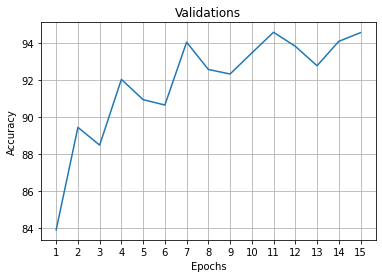

In [0]:
def plot_validation(validation):
  l = []
  for i in validation.values():
    l.append(i)
  x_range = range(1,max(validation.keys())+1)
  plt.plot(x_range, l)
  plt.title('Validations')
  plt.xlabel('Epochs')
  plt.ylabel('Accuracy')
  plt.xticks(x_range)
  plt.grid()
plot_validation(validation)